In [1]:
import torch as tr
import numpy as np

import itertools

from PM_models import *
from PM_tasks import *
from help_amtask import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# sweep 2
- following up on sweep1, using best trained network
- evaluating effect of pre-training
- longer training time

In [171]:
nmaps = 4
ntrials = 2  
switch = 1
wmsize = 6
instdim = 10
stimdim = 12
curr = '1000_99000'
seed = 0
fdir = 'model_data/amtask-barcode/'
fname = 'nmaps_%i-ntrials_%i-switch_%i-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i'%(
            nmaps,ntrials,switch,wmsize,instdim,stimdim,curr,seed)


In [172]:
evsc = np.load(fdir+fname+'-ev_em_0-evsc.npy')
evsc.shape

FileNotFoundError: [Errno 2] No such file or directory: 'model_data/amtask-barcode/nmaps_4-ntrials_2-switch_1-wmsize_6-instdim_10-stimdim_12-curr_1000_99000-seed_0-ev_em_0-evsc.npy'

# sweep 1

In [2]:
nmaps = 4
fdir = 'model_data/amtask-barcode/'
nnets = 20
instdimL=[8,10,12]
stimdimL=[8,10,12]
stsizeL=[4,5,6,8]

In [10]:
def load_trsc2(st,inst,stim,seed,pretrain=True):
  if pretrain:
    curr = '1000_29000'
  else:
    curr = '0_30000'
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-trsc.npy"%(st,inst,stim,curr,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc(st,inst,stim,seed):
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-trsc.npy"%(st,inst,stim,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc_group(st,inst,stim,nnets=20,load_trsc_fn=load_trsc):
  L = []
  for seed in range(nnets):
    trsc = load_trsc_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

In [ ]:
def plt_trsc(ax,trsc,mawind=500):
  '''trsc [sub,neps,ntr,trlen]'''
  cL = ['b','purple']
  for sub in range(len(trsc)):
    for trial in [0,1]:
      trsc_tr = trsc[sub,:,trial,nmaps:].mean(-1)
      tracc = mov_avg(trsc_tr,mawind)
      ax.plot(tracc,c=cL[trial],lw=.5,zorder=100*trial)
      ax.axhline(0.25,c='r',lw=.1,ls='--')
  return None

## training acc

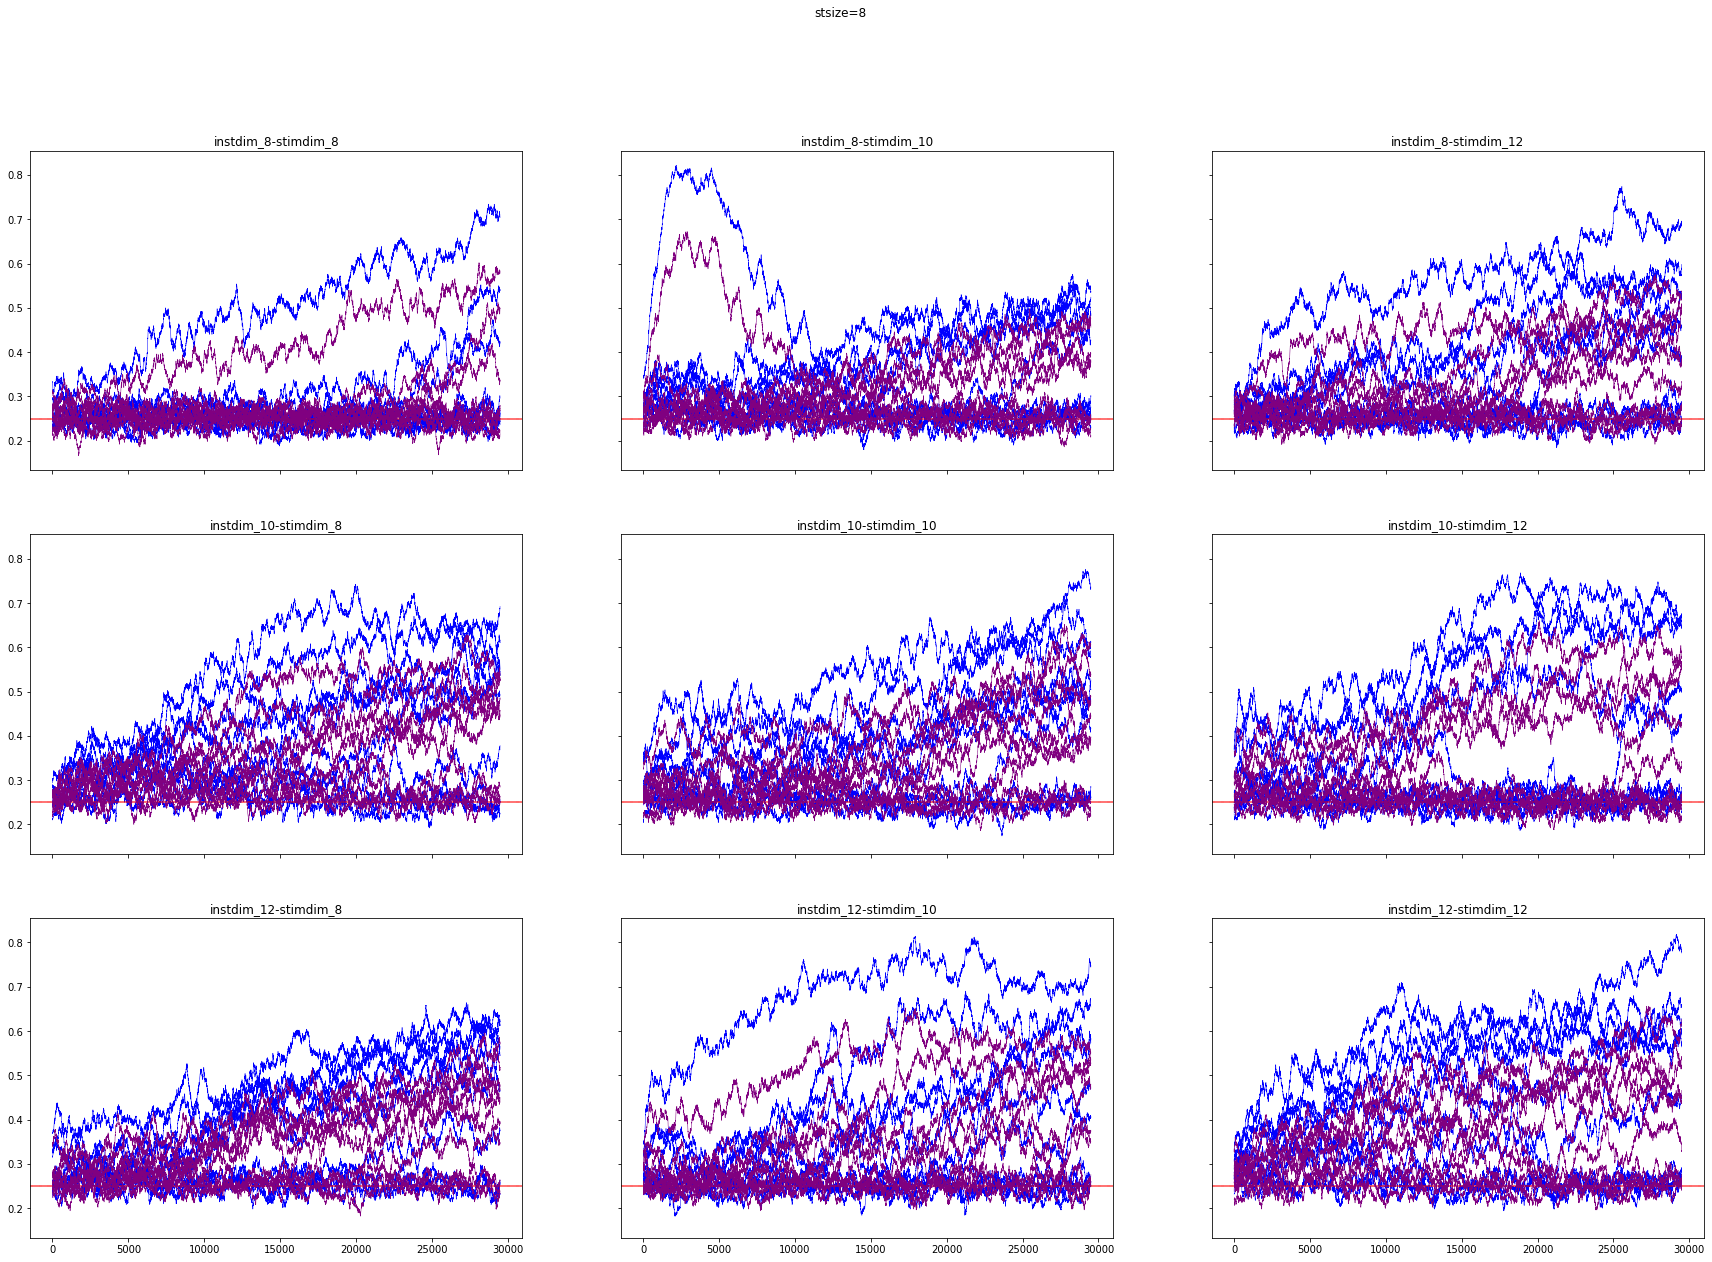

In [4]:
''' plot group 
trial 1 (blue) and 2 (purple) accuracy'''
f=2
nnets = 10
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    trsc = load_trsc_group(st,inst,stim,nnets=nnets,load_trsc_fn=load_trsc2)
    ## plot group data
    plt_trsc(ax,trsc)
#   plt.savefig('figures/amtask-barcodes/tracc/'+'sweep2-nopretrain-stsize-%i'%st)

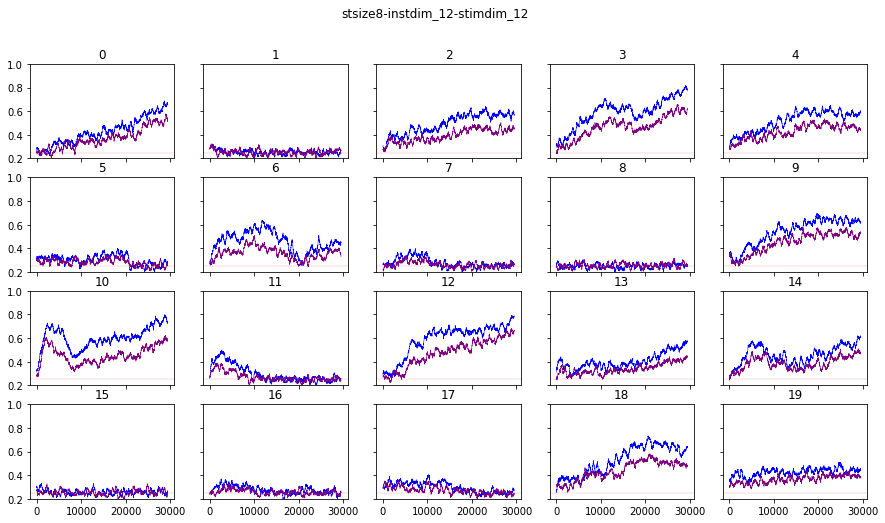

In [5]:
''' plot individual subjects separately
trial 1 (blue) and 2 (purple) accuracy'''
f=1
nnets = 20
for inst,stim,st in itertools.product(stimdimL,instdimL,stsizeL):
  ## load group data
  trsc = load_trsc_group(st,inst,stim,nnets=nnets,load_trsc_fn=load_trsc2)
  plt.close('all')
  fig,axarr = plt.subplots(4,5,figsize=(f*15,f*8),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  title = 'stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim)
  plt.suptitle(title)
  ## loop plot for different subjects
  for idx in range(nnets):
    ax = axarr[idx]
    ax.set_ylim(.2,1)
    ax.set_title(idx)
    ## plot group data
    plt_trsc(ax,trsc[idx:idx+1])
#   plt.savefig('figures/amtask-barcodes/tracc/'+'sweep11-pretrain-stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim))


<Figure size 432x288 with 0 Axes>

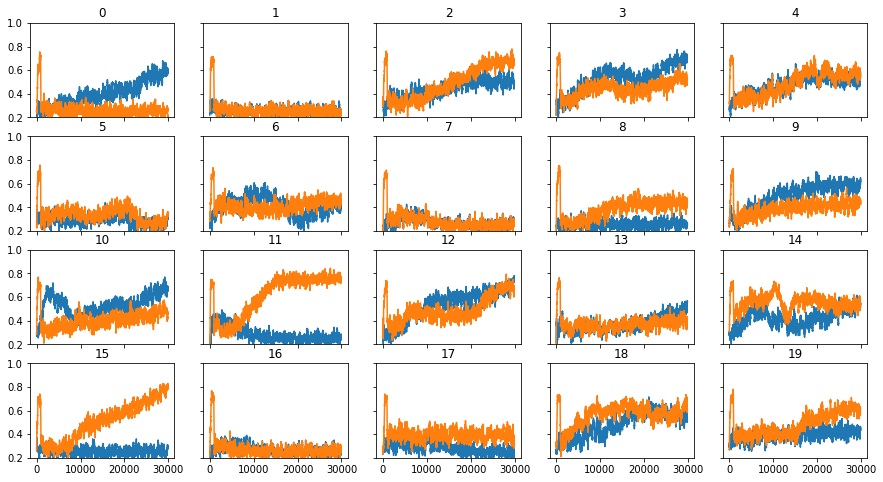

In [32]:
f=1
nnets = 20
for inst,stim,st in itertools.product(stimdimL,instdimL,stsizeL):
  plt.close('all')
  title = 'stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim)
  plt.suptitle(title)
  fig,axarr = plt.subplots(4,5,figsize=(f*15,f*8),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  for idx in range(nnets):
    ax = axarr[idx]
    for pt in [0,1]:
      trsc = load_trsc2(st,inst,stim,seed=idx,pretrain=pt)
      tracc = mov_avg(trsc[:,:,nmaps:].mean((1,2)),100)
      ax.plot(tracc)
    ax.set_ylim(.2,1)
    ax.set_title(idx)
  plt.savefig('figures/amtask-barcodes/tracc/'+'compare_pretrain-stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim))


## eval acc

In [6]:
def load_evsc2(st,inst,stim,seed,pretrain=False):
  if pretrain: curr = '1000_29000'
  else: curr = '0_30000'
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,curr,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc(st,inst,stim,seed):
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc):
  L = []
  for seed in range(nnets):
    trsc = load_data_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

In [7]:
def plt_trial_acc(ax,evsc,plt_subs=True):
  '''evsc [nsubs,(em0,em1),neps,ntr,trlen]
  '''
  evacc = evsc[:,:,:,:,nmaps:].mean((2,-1))
  M = evacc.mean(0)
  S = evacc.std(0)/np.sqrt(len(evacc))
  cL = ['r','b']
  ## plt eval with and without EM
  for em in [0,1]:
    ax.plot(M[em],c=cL[em],lw=2)
    ax.scatter(range(len(M[em])),M[em],c='k')
    ax.fill_between(range(len(M[em])),M[em]-S[em],M[em]+S[em],alpha=.3,color=cL[em])
    if plt_subs:
      for sacc in evacc:
        ax.plot(sacc[em],c=cL[em],lw=.1)
  return None

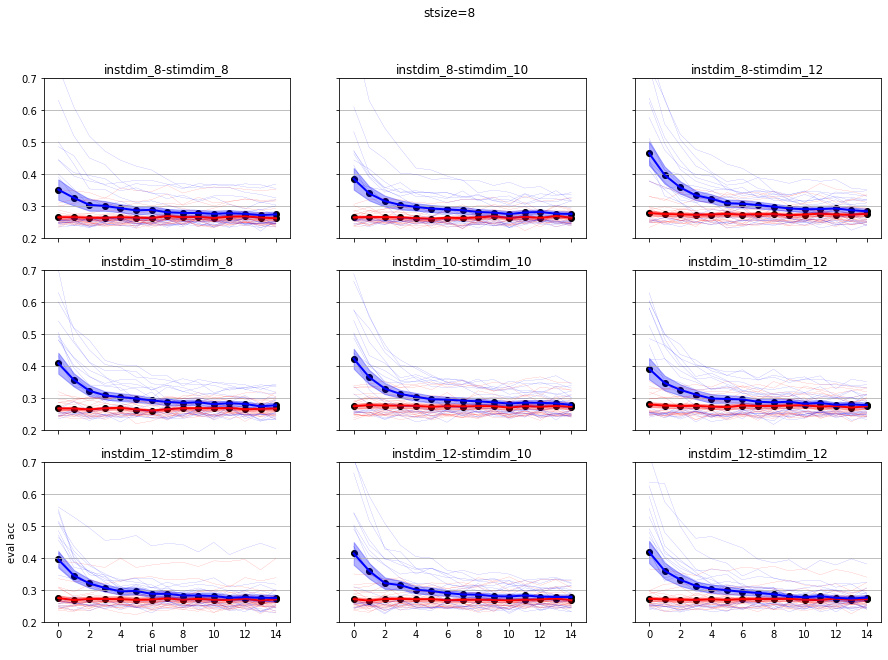

In [8]:
''' group plots comparing eval w/ vs w/o EM'''
f=1
nnets = 20
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  axarr[6].set_xlabel('trial number')
  axarr[6].set_ylabel('eval acc')
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    ax.grid(axis='y')
    ax.set_ylim(0.2,0.7)
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc2)
    ## plot
    plt_trial_acc(ax,evsc)
#   plt.savefig('figures/amtask-barcodes/evacc/'+'sweep2_pretrain-stsize_%i'%st)

Text(0, 0.5, 'eval acc')

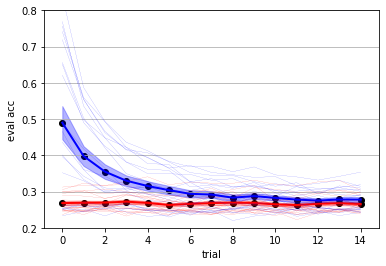

In [11]:
''' best group '''
st,inst,stim = 6,10,12
evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc2)
ax=plt.gca()
ax.set_ylim(.2,.8)
ax.grid(axis='y')
plt_trial_acc(ax,evsc)
ax.set_xlabel('trial')
ax.set_ylabel('eval acc')
# plt.savefig('figures/amtask-barcodes/evacc/st6-inst10-stim12-sweep2')

In [12]:
evsc.shape

(20, 2, 500, 15, 9)

subject mean acc:
 [0.63684444 0.66957037 0.67016296 0.59773333 0.58346667 0.58253333
 0.58173333 0.60468148 0.58257778 0.65857778 0.61505185 0.66557037
 0.61918519 0.65405926 0.58397037 0.61282963 0.64277037 0.52779259
 0.64877037 0.58108148]
highest acc subj:
 2


(0.25, 0.8)

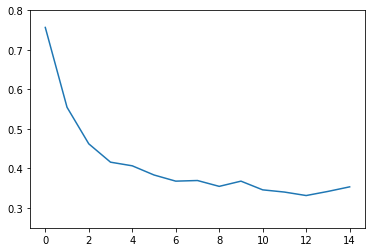

In [16]:
print('subject mean acc:\n',evsc[:,1].mean((-1,-2,-3))) 
print('highest acc subj:\n',np.argmax(evsc[:,1].mean((-1,-2,-3))))
plt.plot(evsc[2,1,:,:,nmaps:].mean((0,2)))
plt.ylim(0.25,0.8)

### analyze eval states

## load net

- analyze best training group st6,inst10,stim12

In [121]:
def load_net(wmsize,inst,stim,seed,pretrain=True):
  if pretrain: curr = '1000_29000'
  else: curr = '0_30000'
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-model.pt"%(wmsize,inst,stim,curr,seed)
  net = NetBarCode(wmsize=wmsize,emsetting=1,seed=seed,instdim=inst,stimdim=stim,debug=False)
  net.load_state_dict(tr.load(fdir+fpath,map_location=tr.device('cpu')))
  return net

def load_netL(wmsize,inst,stim,nnets=20):
  netL = []
  for seed in range(nnets):
    net = load_net(wmsize,inst,stim,seed)
    netL.append(net)
  return netL

In [148]:
# from help_amtask import get_mean_sub_rdm,compute_rdms,get_rdms_full

dist_metric = 'cosine'
compute_rdm = lambda M: distance.cdist(M,M,metric=dist_metric)

def get_mean_sub_rdm(states):
  ''' loop over epochs '''
  neps,tsteps,stsize = states.shape
  rdm = np.zeros([tsteps,tsteps])
  for ep in range(neps):
    rdm += compute_rdm(states[ep])
  rdm = rdm/neps
  return rdm

def plt_rdm(rdm,ax=None,annot=False,plt_range=None):
  if ax==None:
    plt.gca()
  if type(plt_range)==type(None):
    plt_range = [rdm.min(),rdm.max()]
  sns.heatmap(rdm.round(2),ax=ax,
    vmin=plt_range[0],vmax=plt_range[1],
    cbar=False,annot=annot,center=0)
  return None
  

In [120]:
stsize = 6
instdim = 10
stimdim = 12
netL = load_netL(stsize,instdim,stimdim)

seed = 2

In [134]:
neps,ntr,trlen=90,15,1
statesL = []
for seed in range(3):
  net = netL[seed]
  net.debug=False
  net.store_states=True
  task = TaskArbitraryMaps(nmaps,switchmaps=True,ntokens_surplus=0,seed=seed,stimdim=stimdim)
  evsc,subj_states = run_net(net,task,neps,ntr,trlen,training=False,verb=False,return_states=True)
  statesL.append(subj_states)

(3, 90, 75, 6)
(3, 90, 60, 6)
(90, 60, 6)
(60, 6)


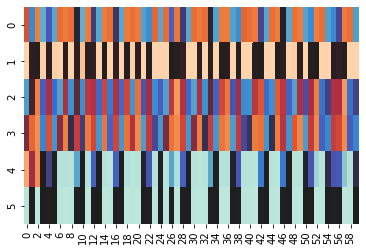

In [150]:
states = np.array(statesL)
nsubs,neps,ntsteps,_,stsize = states.shape
# print(nsubs,neps,ntsteps,_,stsize)

# select h state (EM key)
hc = 0
states = states[:,:,:,hc]
print(states.shape)

# select encoding phase states only
states = states.reshape(nsubs,neps,ntr,nmaps+trlen,stsize)[:,:,:,:nmaps,:].reshape(nsubs,neps,-1,stsize)
print(states.shape)

# for a given subject
sub = 0
states = states[sub]
print(states.shape)

# loop over epochs
ep = 0
states = states[ep]
print(states.shape)

# mean entropy of given epoch
entropy(states)
plt_rdm(states.T)

Text(0.5, 15.0, 'trial')

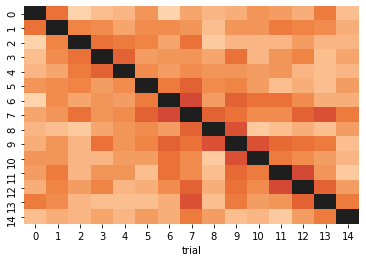

In [118]:
''' '''

def calc_subj_entropy(states):
  '''
  states [epochs,tsteps,stsize]
  '''
def calc_entropy(states):
  '''
  states [nsubs,epochs,tsteps,stsize]
  '''
  
  
hc=0
sub_chstates = states[:,:,ch,:].reshape(neps,ntr,nmaps+trlen,-1)[:,:,nmaps:].squeeze()
subj_rdm = get_mean_sub_rdm(sub_chstates) # for each trial
subj_rdm_entropy = entropy(subj_rdm.flatten())

ax=plt.gca()
plt_rdm(ax,rdm,annot=False,plt_range=None)
ax.set_xlabel('trial')

In [117]:
from scipy.stats import entropy


5.34065728077092

In [52]:
nsubs,tsteps,ch,tstep = states.shape
states.shape

(100, 14, 2, 6)

In [50]:

# states.reshape(nsubs,)
scstates = states[18,:,0,:]
plt.subplots()
for t in range(tstep):
  ax.imshowscstates[:,t].shape

(14, 6)

# train and eval

In [132]:
emsetting=1
wmsize=5
instdim=10
stimdim=12
seed=0

net = NetBarCode(wmsize=wmsize,
                 emsetting=emsetting,
                 seed=seed,
                 instdim=instdim,
                 stimdim=stimdim,
                 debug=False)

nmaps = 4
task = TaskArbitraryMaps(nmaps,
                         switchmaps=True,
                         ntokens_surplus=0,
                         seed=seed,
                         stimdim=stimdim)

In [133]:
trscL = []
emkL = ['stim','conj','stim','conj']
nepsL = [500,10000,500,1000]

for idx in range(len(nepsL)):

  net.emk=emkL[idx]
  trsc = run_net(net,task,nepsL[idx],3,1,training=True,verb=True)
  trscL.append(trsc[:,:,nmaps:])
trsc = np.concatenate(trscL)

0.0 0.0
0.2 0.6666666666666666
0.4 0.9333333333333333
0.6 0.8666666666666667
0.8 0.8
0.0 0.8666666666666667
0.2 0.9333333333333333
0.4 1.0
0.6 0.8666666666666667
0.8 0.8
0.0 0.9333333333333333
0.2 0.9333333333333333
0.4 0.8666666666666667
0.6 0.9333333333333333
0.8 0.8666666666666667
0.0 0.9333333333333333
0.2 0.9333333333333333
0.4 0.8666666666666667
0.6 0.9333333333333333
0.8 0.9333333333333333


In [134]:
print(trsc.shape)
tracc = trsc.mean((2)) 
print(tracc.shape)

(12000, 3, 1)
(12000, 3)


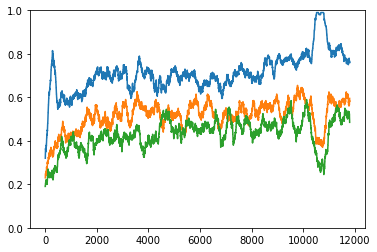

In [136]:
plt.ylim(0,1)
for acc in tracc.T:
  plt.plot(mov_avg(acc,200))

In [111]:
# net.debug=False
# for em in [1,0]:
#   net.EMsetting=em
#   evsc = run_net(net,task,500,10,2,training=False)
#   evacc = evsc[:,:,nmaps:]
#   plt.plot(evacc.mean((0,2)))

In [154]:

nmaps = 4
ntr,trlen = 2,2
trlen += nmaps

np.concatenate([i*np.ones(trlen) for i in range(ntr)])

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])

In [166]:
t,i,x,y = task.gen_ep_data(2,2,True)
ffnet = NetPureEM()

torch.Size([12, 1])